In [1]:
import os
import re
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [2]:
norm_RBP = 'RBP201112A183|RBP201112A181|RBP201112A184|RBP201112A068'
fast_RBP = 'RBP201112A100|RBP201112A236|RBP201112A237|RBP201112A238'
labels = ['0-0.01', '0.01-1', '1-10', '10-100', '>100']

rbp_map = {'RBP201112A183': 'RBP201112A100',
           'RBP201112A181': 'RBP201112A236',
           'RBP201112A184': 'RBP201112A237',
           'RBP201112A068': 'RBP201112A238'}

# Data Wrangling

In [3]:
## Data Wrangling and Covid Ratio Binning ##
df = pd.read_pickle(
    '/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_call.pickle').dropna(how='all', axis=1)
df = df[(df['sample_type'] != 'NTC') & (df['sample_type'] != 'Positive')]
df = df[df['pos_tube_rack'].str.match(r'.*?(A6|B5)') == False]

df['date'] = (df.runid.str[2:4] +
              '-' + df.runid.str[4:6] +
              '-' + df.runid.str[:2]).astype(np.datetime64)
df['RBP'] = df['pos_tube_rack'].str.split(pat=':').str[0]
df['well'] = df['pos_tube_rack'].str.split(pat=':').str[1]
df['row'] = df['pos_tube_rack'].str[14]
df['column'] = df['pos_tube_rack'].str.extract(r'.*?:[A-H](\d+)').astype('int')
df['sample_count'] = 1

df['total_detected'] = df['call'].map({'not_detected': 0,
                                       'detected': 1,
                                       'no_call': np.nan})

df['category'] = pd.cut(df['median_covid_ratio'],
                        [-np.inf, 0.01, 1, 10, 100, np.inf], labels=labels)
dummies = pd.get_dummies(df.category)
df = pd.concat([df, dummies], axis=1)

## Create Normal Extraction df ##
df_norm = df[df['RBP'].str.contains(norm_RBP)].sort_values(
    by=['date', 'row', 'column'], ascending=True).dropna(how='all', axis=1)
df_norm['mapping'] = df_norm.RBP.map(rbp_map)

## Create FAST Extraction df ##
df_fast = df[df['RBP'].str.contains(fast_RBP)].sort_values(
    by=['RBP', 'row', 'column'], ascending=True).dropna(how='all', axis=1)

## Merge Normal and FAST df on RBP Mapping and Well ##
combined = pd.merge(df_norm, df_fast, how='outer', left_on=['mapping', 'well'], right_on=['RBP', 'well'],
                    suffixes=('_norm', '_fast')).sort_values(by='RBP_fast')

# PPA/NPA

In [4]:
binning_norm = combined.groupby('RBP_norm', sort=False).agg({'sample_count_norm': 'sum',
                                                             'date_norm': 'max',
                                                             'total_detected_norm': 'sum',
                                                             '0-0.01_norm': 'sum',
                                                             '0.01-1_norm': 'sum',
                                                             '1-10_norm': 'sum',
                                                             '10-100_norm': 'sum',
                                                             '>100_norm': 'sum'})
binning_norm

,sample_count_norm,date_norm,total_detected_norm,0-0.01_norm,0.01-1_norm,1-10_norm,10-100_norm,>100_norm
RBP_norm,,,,,,,,
RBP201112A183,92,2020-12-05,26.0,66,7,2,2,15
RBP201112A181,92,2020-12-05,14.0,78,3,1,1,9
RBP201112A184,92,2020-12-05,29.0,63,4,4,0,21
RBP201112A068,92,2020-12-03,33.0,59,3,6,9,15


In [5]:
binning_fast = combined.groupby('RBP_fast', sort=False).agg({'sample_count_fast': 'sum',
                                                             'date_fast': 'max',
                                                             'total_detected_fast': 'sum',
                                                             '0-0.01_fast': 'sum',
                                                             '0.01-1_fast': 'sum',
                                                             '1-10_fast': 'sum',
                                                             '10-100_fast': 'sum',
                                                             '>100_fast': 'sum'})
binning_fast

,sample_count_fast,date_fast,total_detected_fast,0-0.01_fast,0.01-1_fast,1-10_fast,10-100_fast,>100_fast
RBP_fast,,,,,,,,
RBP201112A100,92,2020-12-16,25.0,67,7,1,3,14
RBP201112A236,92,2020-12-16,14.0,78,3,2,1,8
RBP201112A237,92,2020-12-16,30.0,62,7,2,2,19
RBP201112A238,92,2020-12-16,32.0,60,5,8,6,13


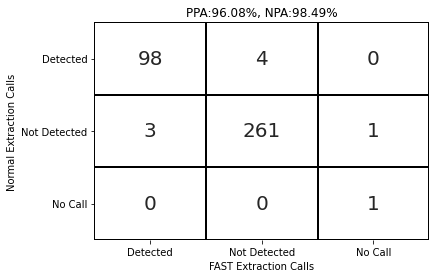

In [21]:
call_labels = ['detected', 'not_detected', 'no_call']

true_calls = list(combined.call_norm.values)
fast_calls = list(combined.call_fast.values)

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls, labels=call_labels)
ax = sns.heatmap(cf_matrix, cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='d',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(['Detected', 'Not Detected', 'No Call'])
ax.set_yticklabels(['Detected', 'Not Detected', 'No Call'])
ax.set_xlabel('FAST Extraction Calls')
ax.set_ylabel('Normal Extraction Calls')

a,b,c,d,e,f,g,h,i = cf_matrix.ravel()

plt.title(f'PPA:{(a*100/(a+b+c)):.2f}%, NPA:{(e*100/(d+e+f)):.2f}%')

plt.yticks(rotation=0)
plt.show()

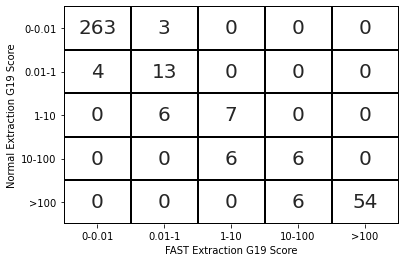

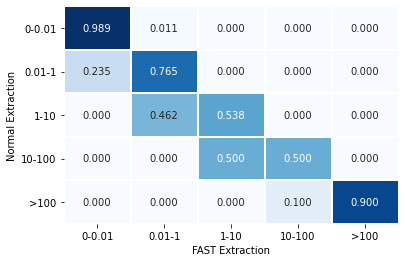

In [22]:
true_calls = list(combined.category_norm.values)
fast_calls = list(combined.category_fast.values)

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls, labels=labels)
ax = sns.heatmap(cf_matrix, cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='d',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('FAST Extraction G19 Score')
ax.set_ylabel('Normal Extraction G19 Score')

plt.yticks(rotation=0)
plt.show()

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls, normalize='true')
ax2 = sns.heatmap(cf_matrix, cmap='Blues', annot=True,
                  linewidths=1, fmt='.3f', cbar=False)
ax2.set_xticklabels(labels)
ax2.set_yticklabels(labels)
ax2.set_xlabel('FAST Extraction')
ax2.set_ylabel('Normal Extraction')

plt.yticks(rotation=0)
plt.show()

# Plate Comparison

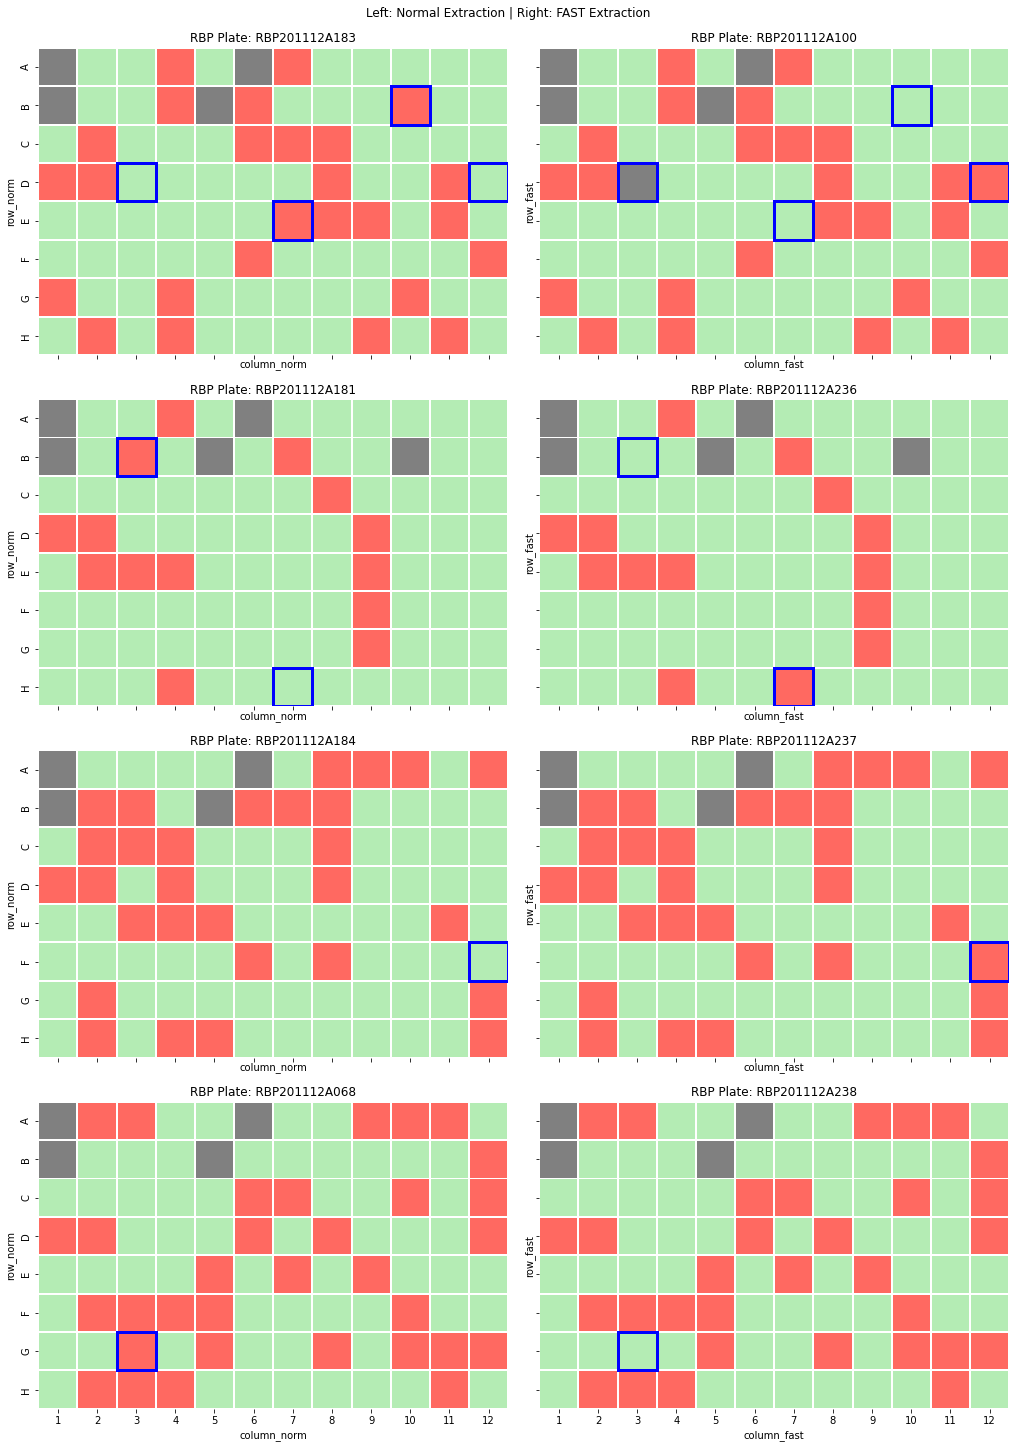

In [23]:
total_cols = 2
total_rows = 4

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, sharex=True, sharey=True,
                        figsize=(7*total_cols, 5*total_rows), constrained_layout=True, squeeze=False)

fig.suptitle(f'Left: Normal Extraction | Right: FAST Extraction')
fig.set_facecolor('white')
ax.tick_params(direction='out', length=6, color='black')

row_to_num = {'A': 0, 'B': 1, 'C': 2, 'D': 3,
              'E': 4, 'F': 5, 'G': 6, 'H': 7}

for i, j, k in zip(combined.RBP_norm.unique(), combined.RBP_fast.unique(), range(4)):

    norm = combined[combined['RBP_norm'] == i]
    norm_pivot = norm.pivot(
        index='row_norm', columns='column_norm', values='total_detected_norm')
    mask_norm = norm_pivot.isnull()

    norm_fig = sns.heatmap(norm_pivot, cbar=False, cmap=ListedColormap(
        ['#b4ecb4', '#ff6961']), ax=axs[k][0], mask=mask_norm, linewidths=1)
    norm_fig.set_facecolor('grey')

    axs[k][0].set_title(f'RBP Plate: {i}')

    fast = combined[combined['RBP_fast'] == j]
    fast_pivot = fast.pivot(
        index='row_fast', columns='column_fast', values='total_detected_fast')
    mask_fast = fast_pivot.isnull()

    fast_fig = sns.heatmap(fast_pivot, cbar=False, cmap=ListedColormap(
        ['#b4ecb4', '#ff6961']), ax=axs[k][1], mask=mask_fast, linewidths=1)
    fast_fig.set_facecolor('grey')
    axs[k][1].set_title(f'RBP Plate: {j}')

    drop_norm = norm[~((norm['total_detected_norm'].isna())
                       & (fast['total_detected_fast'].isna()))]
    drop_fast = fast[~((norm['total_detected_norm'].isna())
                       & (fast['total_detected_fast'].isna()))]

    for i in drop_norm[drop_norm['total_detected_norm'].values != drop_fast['total_detected_fast'].values].loc[:, ['row_norm', 'column_norm']].values:
        norm_fig.add_patch(Rectangle(
            (i[1] - 1, row_to_num[i[0]]), 1, 1, fill=False, edgecolor='blue', lw=3))
        fast_fig.add_patch(Rectangle(
            (i[1] - 1, row_to_num[i[0]]), 1, 1, fill=False, edgecolor='blue', lw=3))

# fig.savefig('fastconcordance2.png', dpi=300)

### Discordant Wells

In [24]:
drop_comb = combined[~((combined['total_detected_norm'].isna())
                       & (combined['total_detected_fast'].isna()))]

drop_comb[(drop_comb['total_detected_norm'] != drop_comb['total_detected_fast'])]\
    .loc[:, ['RBP_norm', 'RBP_fast', 'well', 'median_covid_ratio_norm', 'median_covid_ratio_fast']]

,RBP_norm,RBP_fast,well,median_covid_ratio_norm,median_covid_ratio_fast
144,RBP201112A183,RBP201112A100,B10,0.03013,0.00000
222,RBP201112A183,RBP201112A100,D12,0.00000,0.03546
195,RBP201112A183,RBP201112A100,D3,0.00000,0.00000
243,RBP201112A183,RBP201112A100,E7,0.06926,0.00000
350,RBP201112A181,RBP201112A236,H7,0.00000,0.01422
125,RBP201112A181,RBP201112A236,B3,0.07466,0.00000
295,RBP201112A184,RBP201112A237,F12,0.00000,0.13658
70,RBP201112A068,RBP201112A238,G3,0.05472,0.00680


### Normal Covid Score vs FAST Covid Score

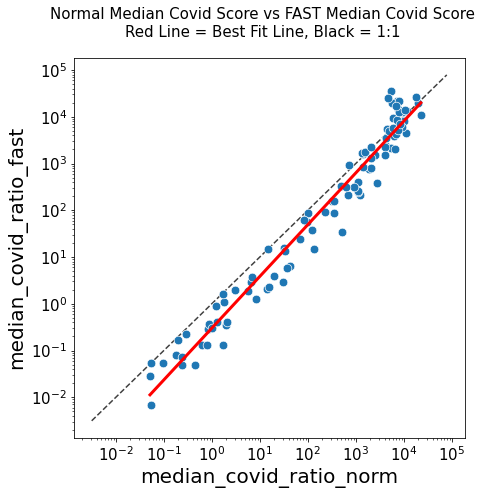

In [25]:
score_relation = combined.query("(total_detected_norm == 1 | total_detected_fast == 1) & \
                                 (median_covid_ratio_norm > 0 & median_covid_ratio_fast > 0)")

fig, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale='log', yscale='log')

sns.scatterplot(data=score_relation, x='median_covid_ratio_norm',
                y='median_covid_ratio_fast', s=75)

x = score_relation['median_covid_ratio_norm'].values
y = score_relation['median_covid_ratio_fast'].values

new_x, new_y = zip(*sorted(zip(x, y)))

logA = np.log(new_x)
logB = np.log(new_y)

m, c = np.polyfit(logA, logB, 1)
y_fit = np.exp(m*logA + c)
plt.plot(new_x, y_fit, 'r', linewidth=3)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
fig.suptitle('Normal Median Covid Score vs FAST Median Covid Score\n\
Red Line = Best Fit Line, Black = 1:1', fontsize=15)

plt.show()

In [27]:
sort_mapping = {'RBP201112A183': 1,
           'RBP201112A181': 2,
           'RBP201112A184': 3,
           'RBP201112A068': 4}

## Look at Singlicate for Discordant Wells ##
singlicate = pd.read_pickle(
    "/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_read_counts.pickle")

singlicate_norm = singlicate[singlicate['run_sample_id'].isin(
    combined.run_sample_id_norm.values)].dropna(how='all', axis=1)
singlicate_fast = singlicate[singlicate['run_sample_id'].isin(
    combined.run_sample_id_fast.values)].dropna(how='all', axis=1)

singlicate_norm['well'] = singlicate_norm['pos_tube_rack'].str.split(
    pat=':').str[1]

singlicate_norm['RBP'] = singlicate_norm['pos_tube_rack'].str.split(
    pat=':').str[0]

singlicate_norm['sort'] = singlicate_norm['RBP'].map(sort_mapping)

singlicate_fast['well'] = singlicate_fast['pos_tube_rack'].str.split(
    pat=':').str[1]

singlicate_fast['RBP'] = singlicate_fast['pos_tube_rack'].str.split(
    pat=':').str[0]

## Create Table of Discordant Sample ID for Normal and FAST ##
drop_comb = combined[~((combined['total_detected_norm'].isna())
                       & (combined['total_detected_fast'].isna()))]
discordant = drop_comb[(drop_comb['total_detected_norm'] != drop_comb['total_detected_fast'])].loc[:, [
    'run_sample_id_norm', 'run_sample_id_fast']]

## Find Discordant Samples for Normal and FAST ##
single_norm = singlicate_norm[singlicate_norm['run_sample_id'].isin(discordant.run_sample_id_norm.values)].loc[:, ['covid_ratio',
        'well', 'RBP', 'sort']].sort_values(by=['sort', 'well', 'covid_ratio']).add_suffix('_norm').reset_index()

single_fast = singlicate_fast[singlicate_fast['run_sample_id'].isin(discordant.run_sample_id_fast.values)].loc[:, ['covid_ratio',
        'well', 'RBP']].sort_values(by=['RBP', 'well', 'covid_ratio']).add_suffix('_fast').reset_index()

## Concat Discordant Samples into one df ##
single_discord = pd.concat(
    [single_norm, single_fast], axis=1).drop(columns='index').loc[:,['well_norm', 'covid_ratio_norm', 'covid_ratio_fast', 'RBP_fast']]
single_discord

,well_norm,covid_ratio_norm,covid_ratio_fast,RBP_fast
0,B10,0.02875,0.00000,RBP201112A100
1,B10,0.03013,0.00000,RBP201112A100
2,B10,0.03259,0.02220,RBP201112A100
3,D12,0.00000,0.00000,RBP201112A100
4,D12,0.00000,0.03546,RBP201112A100
5,D12,0.00002,0.05254,RBP201112A100
6,D3,0.00000,0.00000,RBP201112A100
7,D3,0.00000,0.00000,RBP201112A100
8,D3,0.00000,0.00000,RBP201112A100
9,E7,0.04017,0.00000,RBP201112A100
